In [1]:
# STEP 1: Install dependencies
!pip install tensorflow tensorflow-addons

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 7.3 MB/s eta 0:00:00
  Attempting uninstall: typeguard
    Found existing installation: typeguard 4.4.4
    Uninstalling typeguard-4.4.4:
      Successfully uninstalled typeguard-4.4.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
inflect 7.5.0 requires typeguard>=4.0.1, but you have typeguard 2.13.3 which is incompatible.


In [2]:
# STEP 1: Install dependencies
!pip install tensorflow tensorflow-addons

# STEP 2: Import libraries
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
import zipfile
import os
import shutil
import matplotlib.pyplot as plt

# STEP 3: Unzip the dataset
zip_path = "/content/GovtIdDataset 2.zip"
extract_path = "/content/GovtIdDataset"
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# STEP 4: Clean dataset folder
# Remove __MACOSX if present
macosx_path = os.path.join(extract_path, "__MACOSX")
if os.path.exists(macosx_path):
    shutil.rmtree(macosx_path)
    print("Removed __MACOSX folder.")

# Remove nested 'GovtIdDataset 2' if present
nested_path = os.path.join(extract_path, "GovtIdDataset 2")
if os.path.exists(nested_path):
    for item in os.listdir(nested_path):
        src_item = os.path.join(nested_path, item)
        dest_item = os.path.join(extract_path, item)
        if not os.path.exists(dest_item):
            shutil.move(src_item, extract_path)
            print(f"Moved {item} to dataset root.")
        else:
            print(f"Skipped {item}, already exists at destination.")
    shutil.rmtree(nested_path)
    print("Flattened nested 'GovtIdDataset 2' folder.")

# Rename folders to remove trailing spaces
for folder in os.listdir(extract_path):
    old_path = os.path.join(extract_path, folder)
    new_name = folder.strip()
    new_path = os.path.join(extract_path, new_name)
    if old_path != new_path:
        os.rename(old_path, new_path)
        print(f"Renamed folder '{folder}' -> '{new_name}'")

# Confirm final structure
print("\nFinal dataset structure:")
!ls "$extract_path"

Removed __MACOSX folder.
Moved .DS_Store to dataset root.
Moved DrivingLicense to dataset root.
Moved Passport to dataset root.
Moved ID  to dataset root.
Flattened nested 'GovtIdDataset 2' folder.
Renamed folder 'ID ' -> 'ID'

Final dataset structure:
DrivingLicense	ID  Passport


In [3]:
dataset_dir = "/content/GovtIdDataset"

In [4]:
IMG_SIZE = 224
BATCH_SIZE = 16

train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,  # 80% train, 20% validation
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True
)

train_generator = train_datagen.flow_from_directory(
    dataset_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

val_generator = train_datagen.flow_from_directory(
    dataset_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

Found 92 images belonging to 3 classes.
Found 22 images belonging to 3 classes.


In [5]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# Build MobileNetV2 model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze the base model

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(3, activation='softmax')  # 3 classes
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Show model summary
model.summary()

# Train the model
EPOCHS = 10

history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator
)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,339 (9.24 MB)

 Trainable params: 164,355 (642.01 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 729ms/step - accuracy: 0.3323 - loss: 1.4351

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


6/6 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step - accuracy: 0.3392 - loss: 1.4098 - val_accuracy: 0.6818 - val_loss: 0.8346
Epoch 2/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.5339 - loss: 0.9919 - val_accuracy: 0.5455 - val_loss: 0.8258
Epoch 3/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.5522 - loss: 0.9426 - val_accuracy: 0.7273 - val_loss: 0.7737
Epoch 4/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.6819 - loss: 0.7815 - val_accuracy: 0.7273 - val_loss: 0.7515
Epoch 5/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.6470 - loss: 0.7796 - val_accuracy: 0.6818 - val_loss: 0.7275
Epoch 6/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.5992 - loss: 0.9413 - val_accuracy: 0.8636 - val_loss: 0.6987
Epoch 7/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 6s 959ms/step - accuracy: 0.6903 - loss: 0.7173 - val_accuracy: 0.5909 - val_loss: 0.7164
Epoch 8/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.7325 - loss: 0.6284 - val_accuracy: 0.6818 - val_loss: 0.6481
Epoch 9/10
6/6 ━━━━━━━━

In [6]:
# Set base_model.trainable = True to fine-tune MobileNetV2
base_model.trainable = True

# Optionally: Freeze earlier layers, unfreeze only top layers
for layer in base_model.layers[:-30]:  # Freeze all but last 30 layers
    layer.trainable = False

# Compile again with a smaller learning rate
model.compile(optimizer=Adam(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Continue training for 10 more epochs
fine_tune_epochs = 10
total_epochs = EPOCHS + fine_tune_epochs

history_fine = model.fit(
    train_generator,
    epochs=total_epochs,
    initial_epoch=history.epoch[-1],  # Start where you left off
    validation_data=val_generator
)

Epoch 10/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step - accuracy: 0.6097 - loss: 0.7988 - val_accuracy: 0.7727 - val_loss: 0.5792
Epoch 11/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.7489 - loss: 0.6552 - val_accuracy: 0.7727 - val_loss: 0.5530
Epoch 12/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.7219 - loss: 0.6694 - val_accuracy: 0.6818 - val_loss: 0.6714
Epoch 13/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.7702 - loss: 0.6353 - val_accuracy: 0.7273 - val_loss: 0.5632
Epoch 14/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.7634 - loss: 0.5270 - val_accuracy: 0.6818 - val_loss: 0.5658
Epoch 15/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.8555 - loss: 0.5405 - val_accuracy: 0.8182 - val_loss: 0.4972
Epoch 16/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.8581 - loss: 0.5049 - val_accuracy: 0.8182 - val_loss: 0.4786
Epoch 17/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.8215 - loss: 0.5371 - val_accuracy: 0.8636 - val_loss: 0.5002
Epoch 

In [17]:
# Set base_model.trainable = True to fine-tune MobileNetV2
base_model.trainable = True

# Optionally: Freeze earlier layers, unfreeze only top layers
for layer in base_model.layers[:-30]:  # Freeze all but last 30 layers
    layer.trainable = False

# Compile again with a smaller learning rate
model.compile(optimizer=Adam(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Continue training for 10 more epochs
fine_tune_epochs = 10
total_epochs = EPOCHS + fine_tune_epochs

history_fine = model.fit(
    train_generator,
    epochs=total_epochs,
    initial_epoch=history.epoch[-1],  # Start where you left off
    validation_data=val_generator
)

Epoch 10/20


/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8664 - loss: 0.4198

/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


6/6 ━━━━━━━━━━━━━━━━━━━━ 25s 4s/step - accuracy: 0.8684 - loss: 0.4163 - val_accuracy: 0.8636 - val_loss: 0.4660
Epoch 11/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 23s 4s/step - accuracy: 0.8992 - loss: 0.4015 - val_accuracy: 0.8182 - val_loss: 0.4444
Epoch 12/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 24s 4s/step - accuracy: 0.8807 - loss: 0.4014 - val_accuracy: 0.8636 - val_loss: 0.4435
Epoch 13/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 24s 4s/step - accuracy: 0.9164 - loss: 0.3153 - val_accuracy: 0.8636 - val_loss: 0.4344
Epoch 14/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 23s 4s/step - accuracy: 0.9644 - loss: 0.2948 - val_accuracy: 0.7727 - val_loss: 0.4794
Epoch 15/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 22s 4s/step - accuracy: 0.9280 - loss: 0.2999 - val_accuracy: 0.8636 - val_loss: 0.3784
Epoch 16/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 25s 4s/step - accuracy: 0.9534 - loss: 0.3110 - val_accuracy: 0.8636 - val_loss: 0.4336
Epoch 17/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 38s 4s/step - accuracy: 0.9275 - loss: 0.3208 - val_accuracy: 0.8636 - val_loss: 0.3961
Epoch 18/20


In [18]:
import tensorflow as tf
tf.config.run_functions_eagerly(True)

In [19]:
model.save("document_classifier_mobilenetv2_final.h5")
print("Model saved as document_classifier_mobilenetv2_final.h5")

Model saved as document_classifier_mobilenetv2_final.h5


Model loaded successfully.


Saving PAN Card.jpg to PAN Card.jpg


/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 554ms/step


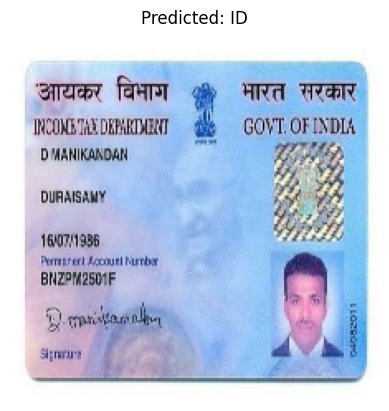

Prediction: ID


In [24]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
import numpy as np
from google.colab import files
import matplotlib.pyplot as plt
import tensorflow as tf

# Load the saved model
model = load_model("document_classifier_mobilenetv2_final.h5")
print("Model loaded successfully.")

# Upload an image
uploaded = files.upload()

for file_name in uploaded.keys():
    # Load and preprocess the image
    img_path = file_name
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = img_array / 255.0  # Normalize

    # Predict
    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions, axis=1)

    # Map class index to label
    class_indices = train_generator.class_indices
    class_labels = {v: k for k, v in class_indices.items()}
    predicted_label = class_labels[predicted_class[0]]

    # Show the image and prediction
    plt.imshow(img)
    plt.title(f"Predicted: {predicted_label}")
    plt.axis('off')
    plt.show()

    print(f"Prediction: {predicted_label}")